# Resources

https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/

https://github.com/vwxyzjn/cleanrl?tab=readme-ov-file

In [13]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import torch
from torch import nn
from torch.nn import init
import torch.nn.functional as F
from torch.distributions import Categorical
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import time
import uuid
import pickle

from stable_baselines3.common.atari_wrappers import ClipRewardEnv, FireResetEnv, MaxAndSkipEnv, NoopResetEnv

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Params

In [14]:
ENV_ARGS = {
    'id': "BreakoutNoFrameskip-v4"
}
NUM_ENVS = 6
SEED = 1
LR = 3e-4
NUM_STEPS = 2048
NUM_ITERATIONS = 1000
GAMMA = 0.99
GAE_LAMBDA = 0.95
UPDATE_EPOCHS = 10
CLIP_COEF = 0.2 # the epsilon in KL divergece in PPO paper
ENTROPY_COEF = 0.0
VF_COEF = 0.5
MAX_GRAD_NORM = 0.5
MINI_BATCH_COUNT = 32
UPDATE_PLOTS = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device = ', DEVICE)

#output directory
ROOT = os.getcwd()
OUTPUT = os.path.join(ROOT, 'output', ENV_ARGS['id'])

if os.path.exists(OUTPUT) == False:
    os.makedirs(OUTPUT)

#seeding
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device =  cuda


In [ ]:
gym.envs.registration.registry.keys()

In [16]:
env = gym.make(**ENV_ARGS)

# Make envs

In [17]:
def make_env(**env_args):
    env = gym.make(**env_args)
    # env = gym.wrappers.FlattenObservation(env)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip = 4)

    env = ClipRewardEnv(env)
    env = gym.wrappers.ResizeObservation(env, (84,84)) 
    env = gym.wrappers.GrayScaleObservation(env) 
    env = gym.wrappers.FrameStack(env, 4) 
    return env


In [18]:
# Test env
envs = gym.vector.SyncVectorEnv(
    [lambda : make_env(**ENV_ARGS) for _ in range(NUM_ENVS)]
) 

assert isinstance(envs.single_action_space, gym.spaces.Discrete), 'Only discrete action is supported'

# Model

In [19]:
def layer_init(layer: nn.Linear, std = np.sqrt(2), bias_const = 0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class Agent(nn.Module):

    def __init__(self, envs: gym.Env, hidden_size: int = 512):

        super().__init__()

        self.network = nn.Sequential(
            layer_init(nn.Conv2d(4, 32, 8, stride = 4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 4, stride = 2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride = 1)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(64 * 7 * 7, hidden_size)),
            nn.ReLU(),
        )

        self.actor = layer_init(nn.Linear(hidden_size, envs.single_action_space.n), std = 0.01)
        self.critic = layer_init(nn.Linear(hidden_size,1 ), std = 1.0)
    
    def get_value(self, x):
        return self.critic(self.network(x/255.0))
    
    def get_action_and_value(self, x, action = None):
        '''
        @params:
            x: torch.tensor observation, shape = (N, observation size)
            action: torch.tensor action
        @returns:
            action: torch.tensor, shape = (N, action size)
            log_prob: torch.tensor, shape = (N,)
            entropy: torch.tensor, shape = (N,)
            value: torch.tensor, shape = (N,)
        '''

        hidden = self.network(x/255.0)
        logits = self.actor(hidden)
        probs = Categorical(logits=logits)
        if action == None:
            action = probs.sample()

        log_prob = probs.log_prob(action)
        entropy = probs.entropy()
        value = self.critic(hidden)
        return action, log_prob, entropy, value
  

In [20]:
#Test agent
# Test env
envs = gym.vector.SyncVectorEnv(
    [lambda : make_env(**ENV_ARGS) for _ in range(NUM_ENVS)]
) 

assert isinstance(envs.single_action_space, gym.spaces.Discrete), 'Only discrete action is supported'

obs, info = envs.reset()
obs = torch.tensor(obs).float()
print('obs shape = ', obs.shape)

test_agent = Agent(envs)

action, log_prob, entropy, value = test_agent.get_action_and_value(obs)

print('action shape = ', action.shape)
print('log prob shape = ', log_prob.shape)
print('entropy shape = ', entropy.shape)
print('value shape = ', value.shape)

envs.close()
del test_agent


obs shape =  torch.Size([6, 4, 84, 84])
action shape =  torch.Size([6])
log prob shape =  torch.Size([6])
entropy shape =  torch.Size([6])
value shape =  torch.Size([6, 1])


# Utils

In [21]:
def plot(history, show = False, save_path = None):
    sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))))

    if save_path != None:
        plt.savefig(save_path)
    if show:
        plt.show()
        
    plt.clf()
    plt.close()

In [22]:
def evaluate(agent, episodes = 10):
    envs = gym.vector.SyncVectorEnv([lambda: make_env(gamma = GAMMA, **ENV_ARGS)])
    agent.eval()
    total_rewards = []
    next_obs, _ = envs.reset()

    while len(total_rewards) < episodes: 
        next_obs = torch.Tensor(next_obs)
        with torch.no_grad():
            action, log_prob, _, value = agent.get_action_and_value(next_obs)

        next_obs, reward, terminated, truncated, info = envs.step(action.numpy())

        if 'final_info' in info:
            for data in info['final_info']:
                if data:
                    reward = data['episode']['r'][0]
                    total_rewards.append(reward)

    return total_rewards

# Training loop

In [23]:
def tune(envs, agent, optimizer, num_steps, num_envs, device, 
         num_iterations = 1000, update_epochs = 10,
         label = 'test', plot_udpate_freq = 10, history = None):

    # label = str(uuid.uuid4()).split('-')[0]
    agent.to(device)

    print('run id = ', label)
    SAVE_PATH = os.path.join(OUTPUT, label)
    FIG_SAVE_PATH = os.path.join(SAVE_PATH, 'plot.png')
    if os.path.exists(SAVE_PATH) == False:
        print(f'output folder: {SAVE_PATH}')
        os.makedirs(SAVE_PATH)
    print('save path = ', SAVE_PATH)

    M,N = num_steps, num_envs

    obs = torch.zeros((M, N) + envs.single_observation_space.shape).to(device)
    actions = torch.zeros((M,N) + envs.single_action_space.shape).to(device)
    log_probs = torch.zeros((M,N)).to(device)
    rewards = torch.zeros((M,N)).to(device)
    dones = torch.zeros((M,N)).to(device) # for masking
    values = torch.zeros((M,N)).to(device)

    global_step = 0

    #Reset env
    next_obs, _ = envs.reset()
    next_obs = torch.tensor(next_obs).float().to(device)
    next_done = torch.zeros(N).to(device) #N is num envs

    print('next obs = ', next_obs.shape)
    print('next done = ', next_done.shape)

    reward_window = deque(maxlen = 100)

    if history == None:
        history = defaultdict(list)

    loop = tqdm(range(num_iterations))
    agent.train()

    best_score = -float('inf')
    loss = float('inf')

    for iter in loop:

        #ROLLOUT phase
        #M is max steps
        if iter % plot_udpate_freq == 0:
            plot(history, save_path=FIG_SAVE_PATH)

        for step in range(M):
            global_step += N

            obs[step] = next_obs
            dones[step] = next_done

            #get action
            #NOTE: no_grad disables gradient calculation --> reduce memory consumption
            #the result of every computation will have requires_grad=False
            with torch.no_grad():
                action, log_prob, _, value = agent.get_action_and_value(next_obs)
                values[step] = value.flatten()

            actions[step] = action
            log_probs[step] = log_prob

            #make next step with actions
            next_obs, reward, terminated, truncated, info = envs.step(action.cpu().numpy())

            next_done = np.logical_or(terminated, truncated)

            #NOTE: difference between view and reshape
            # https://stackoverflow.com/questions/49643225/whats-the-difference-between-reshape-and-view-in-pytorch
            rewards[step] = torch.tensor(reward).view(-1)
            next_obs = torch.tensor(next_obs).float().to(device)
            next_done = torch.tensor(next_done).float().to(device)

            #NOTE: vector envs will automatically reset, so no need to break 
            if 'final_info' in info:
                for data in info['final_info']:
                    if data:
                        reward = data['episode']['r']
                        reward_window.append(reward)
                        avg_reward = np.mean(reward_window)
                        history['reward'].append(avg_reward)
                        loop.set_description(f"reward = {avg_reward:.2f}, global_step = {global_step}, best_score = {best_score:.2f}, loss={loss:.2f}")

                        if best_score < avg_reward:
                            best_score = avg_reward
                            #save model
                            torch.save(agent, os.path.join(SAVE_PATH, 'ppo.checkpoint.torch'))
            
        #update the history for plotting, and printing progress

        #OPTIMIZE phase:
        with torch.no_grad():
            #bootstrap values, compute returns
            next_value = agent.get_value(next_obs).reshape(1,-1)
            advantages = torch.zeros_like(rewards).to(device)
            last_gae_lambda = 0

            for t in reversed(range(NUM_STEPS)):
                if t == NUM_STEPS - 1:
                    next_none_terminal = np.logical_not(next_done.cpu())
                    next_values = next_value
                else:
                    next_none_terminal = np.logical_not(dones[t + 1].cpu())
                    next_values = values[t + 1]

                next_none_terminal = next_none_terminal.to(device)
                
                #A(s,a) = Q(s,a) - V(s,a) = r(t) + gamma * V(s', a) * mask - V(s)
                delta = rewards[t] + GAMMA * next_values * next_none_terminal - values[t]
                #NOTE: learn about this formula
                advantages[t] = last_gae_lambda = delta + GAMMA * GAE_LAMBDA * next_none_terminal * last_gae_lambda
            returns = advantages + values
        
        #flatten the batch
        b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
        b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
        b_log_probs = log_probs.reshape(-1)
        b_advantages = advantages.reshape(-1)
        b_returns = returns.reshape(-1)
        b_values = values.reshape(-1)

        #NOTE: randomize the batch to break correlation
        batch_size = M * N
        mini_batch_size = batch_size // MINI_BATCH_COUNT
        b_indicies = np.arange(batch_size)
        clip_fracs = []
        
        for _ in range(update_epochs):
            np.random.shuffle(b_indicies)

            #NOTE: mini-batch update: 
            # pros: reduce memory usage, faster updates
            # pros: a whole batch may stuck in local minima, mini batches introduce randomness
            # cons: estimate a true gradient, larger mini batch size --> more accurate but more memory
            for start in range(0, batch_size, mini_batch_size):
                end = start + mini_batch_size
                mini_indicies = b_indicies[start:end]

                _, new_log_prob, entropy, new_value = agent.get_action_and_value(b_obs[mini_indicies], b_actions[mini_indicies])

                #NOTE: what formula is this? 
                log_ratio = new_log_prob - b_log_probs[mini_indicies]

                ratio = log_ratio.exp() # trick to remove log

                #compute approximate KL: http://joschu.net/blog/kl-approx.html
                with torch.no_grad():
                    old_approx_kd = (-log_ratio).mean()
                    approximate_kl = ((ratio - 1) - log_ratio).mean()
                    clip_fracs += [((ratio - 1.0).abs() > CLIP_COEF).float().mean().item()]

                mb_advantages = b_advantages[mini_indicies]

                #normalize advantage
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

                #policy loss (actor)

                pg_loss1 = -mb_advantages * ratio
                pg_loss2= -mb_advantages * torch.clamp(ratio, 1 - CLIP_COEF, 1 + CLIP_COEF)

                pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                new_value = new_value.view(-1)

                #value loss (MSE)
                v_loss = 0.5 * ((new_value - b_returns[mini_indicies]) ** 2).mean()

                entropy_loss = entropy.mean()

                loss = pg_loss - ENTROPY_COEF * entropy_loss + v_loss * VF_COEF

                optimizer.zero_grad()
                loss.backward()
                #clip grad
                nn.utils.clip_grad_norm_(agent.parameters(), MAX_GRAD_NORM)
                optimizer.step()
        
    torch.save(agent, os.path.join(SAVE_PATH, 'ppo.final.torch'))
    plot(history, show=True, save_path=FIG_SAVE_PATH)

    with open(os.path.join(SAVE_PATH, 'history.pickle'), 'wb') as file:
        pickle.dump(history, file)


# Tune

In [24]:
# Create env
envs = gym.vector.AsyncVectorEnv(
    [lambda : make_env(**ENV_ARGS) for _ in range(NUM_ENVS)]
) 
#check to make sure this is continous action
# assert isinstance(envs.single_action_space, gym.spaces.Box), 'Only continous action is supported'

agent = Agent(envs)
optimizer = torch.optim.Adam(agent.parameters(), lr = 1e-4, eps = 1e-5)

M = NUM_STEPS
N = NUM_ENVS

tune(envs, agent, optimizer, NUM_STEPS, NUM_ENVS, device=  DEVICE, num_iterations=1000, label = 'baseline', update_epochs=20)

run id =  baseline
output folder: e:\ML\NLP\Reinforcement Learning\policy_gradient\final_project\ppo\output\BreakoutNoFrameskip-v4\baseline
save path =  e:\ML\NLP\Reinforcement Learning\policy_gradient\final_project\ppo\output\BreakoutNoFrameskip-v4\baseline
next obs =  torch.Size([6, 4, 84, 84])
next done =  torch.Size([6])


reward = 1.46, global_step = 48990, best_score = 1.73, loss=0.01:   0%|          | 3/1000 [01:55<8:46:56, 31.71s/it] 

# Evaluation

In [88]:
def evaluate(agent, device = DEVICE, episodes = 10):
    envs = gym.vector.SyncVectorEnv([lambda: make_env(**ENV_ARGS)])
    agent.eval()
    total_rewards = []
    next_obs, _ = envs.reset()

    while len(total_rewards) < episodes: 
        next_obs = torch.Tensor(next_obs).to(device)
        with torch.no_grad():
            action, log_prob, _, value = agent.get_action_and_value(next_obs)

        next_obs, reward, terminated, truncated, info = envs.step(action.cpu().numpy())

        if 'final_info' in info:
            for data in info['final_info']:
                if data:
                    reward = data['episode']['r'][0]
                    print('reward = ', reward)
                    total_rewards.append(reward)
    
    sns.lineplot(y = total_rewards, x = list(range(len(total_rewards))))
    return total_rewards

reward =  41.0
reward =  80.0
reward =  24.0
reward =  33.0
reward =  45.0
reward =  47.0
reward =  54.0
reward =  260.0
reward =  31.0
reward =  28.0


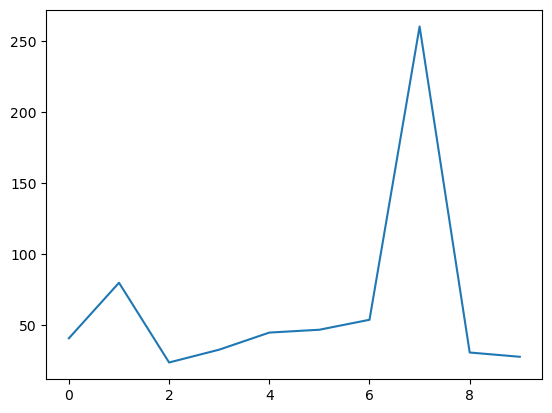

In [89]:
data = evaluate(agent)
